In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim
from torchinfo import summary
from tqdm import tqdm
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset

In [2]:
x_train = np.load('x_train2.npy')
y_train = np.load('y_train2.npy')
x_train = np.around(x_train,5)
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
y_train = torch.reshape(y_train,(10000,7))
# x_train = x_train[:100]
# y_train = y_train[:100]
print('x_train',x_train.shape, x_train.min(), x_train.max())
print('y_train',y_train.shape, y_train.min(), y_train.max())

x_train torch.Size([10000, 1, 40, 40]) tensor(0.) tensor(1.)
y_train torch.Size([10000, 7]) tensor(-0.2000) tensor(0.2000)


In [4]:
# 1. Définir le modèle avec nn.Sequential
class SimpleCNN(nn.Module):
    def __init__(self, output_size):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            # Convolutional layer
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            # Flatten layer
            nn.Flatten(),
            # Fully connected layer
            nn.Linear(16 * 20* 20, output_size)
        )
    
    def forward(self, x):
        x = self.model(x)
        x = torch.round(x * 100) / 100# Arrondir les sorties à deux décimales
        return x

# Paramètres
output_size = 7

In [5]:
device = torch.device('cpu')

In [6]:
class ResNet50Custom(nn.Module):
    def __init__(self):
        super(ResNet50Custom, self).__init__()
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        #Adapter la première couche pour accepter 1 canal au lieu de 3
        self.resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Remplacer la dernière couche fully connected
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, 7) # nombre de para de sortie
    
    def forward(self, x):
        x = self.resnet50(x)
        #x = torch.round(x * 1000) / 1000# Arrondir les sorties à deux décimales
        return x
    

In [7]:
# Transformation pour adapter la taille d'entrée attendue par ResNet50
transform = transforms.Compose([
    transforms.Resize((224, 224)),
])

# Appliquer la transformation sur les entrées
x_train = torch.stack([transform(input) for input in x_train]).to(device)

In [17]:
model = ResNet50Custom().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)#optim.SGD(model.parameters(), lr=0.01)#

In [16]:
#model(x_train).to(device)

In [9]:
# 4. Boucle d'entraînement avec enregistrement des pertes
# epochs = 50
# losses = []
# with tqdm(range(epochs), unit='epoch') as tepoch :
#     for epoch in tepoch:

#         # Forward pass
#         outputs = model(x_train)
#         loss = criterion(outputs, y_train)
#         losses.append(loss.item())
#         optimizer.zero_grad () # clean up step
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
#         tepoch.set_postfix(loss=loss.item())

In [10]:
# # 5. Tracer le graphique de la perte d'entraînement
# plt.plot(losses)
# plt.xlabel('Époque')
# plt.ylabel('Perte')
# plt.title('Perte d\'entraînement au fil des époques')
# plt.show()

In [11]:
# with torch.no_grad():
#     # Extraire la deuxième image de inputs
#     test_input = x_train[4].unsqueeze(0)  # Ajouter une dimension batch
#     predicted_output = model(test_input)
# print(predicted_output)


In [18]:
def compute_accuracy(outputs, targets):
    """Fonction pour calculer l'accuracy"""
    with torch.no_grad():
        # Convertir les prédictions en classes prédites
        _, predicted = torch.max(outputs, 1)
        # Calculer le nombre de prédictions correctes
        correct = (predicted == targets).sum().item()
        # Calculer l'accuracy
        accuracy = correct / targets.size(0)
    return accuracy

In [13]:
# optimisation stochastique , mini-batch
epochs = 50 # nombre d'epoch
losses = []
batch_size = 64
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
losses = []
accuracies = []
with tqdm(range(epochs), unit='epoch') as tepoch :
    for epoch in tepoch:
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        
        for batch_inputs, batch_targets in dataloader:
            # Déplacer les données sur l'appareil
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)
            #print(batch_inputs.shape,batch_targets.shape)
            # Forward pass
            outputs = model(batch_inputs)
            #print('outputs',outputs.shape)
            loss = criterion(outputs, batch_targets )
            losses.append(loss.item())
        
            # Backward pass and optimization
            optimizer.zero_grad () # clean up step
            loss.backward()
            optimizer.step()
            batch_accuracy = compute_accuracy(outputs, batch_targets.argmax(dim=1))
            epoch_accuracy += batch_accuracy
        
        # Calculer l'accuracy moyenne par époque
        epoch_loss /= len(dataloader)
        epoch_accuracy /= len(dataloader)
    
        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)
        tepoch.set_postfix(loss=loss.item())

  0%|          | 0/50 [00:00<?, ?epoch/s]

100%|██████████| 50/50 [10:37:29<00:00, 764.99s/epoch, loss=0.018]  


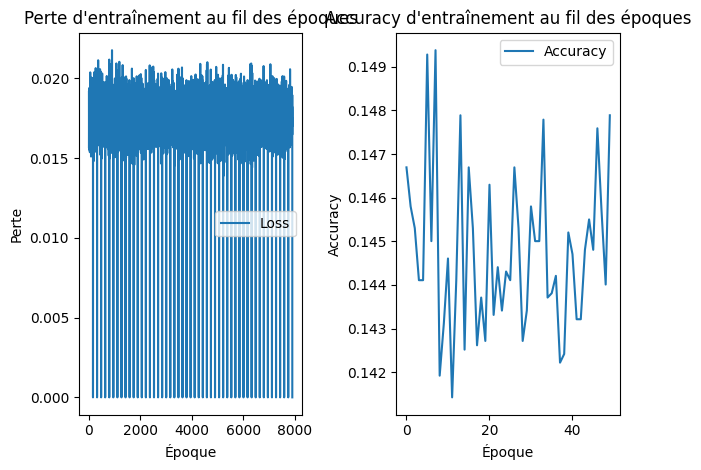

In [14]:
# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Perte d\'entraînement au fil des époques')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.title('Accuracy d\'entraînement au fil des époques')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
with torch.no_grad():
    # Extraire la deuxième image de inputs
    test_input = x_train[4].unsqueeze(0)  # Ajouter une dimension batch
    predicted_output = model(test_input)
print(predicted_output)

tensor([[-0.0390, -0.0160,  0.0270,  0.0880, -0.0860, -0.0090, -0.0850]])
